Device: cuda
TF-IDF max features: 20000
Loaded 882519 texts, 7 classes: ['Pray' 'anger' 'fear' 'happy' 'neutral' 'ps' 'sad']
Fitting TF-IDF on training texts...
TF-IDF vocabulary size (input dim): 20000
Train batches: 22063 Val batches: 5516


C:\Users\Administrator\AppData\Local\Temp\ipykernel_23348\721823274.py:205: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if DEVICE.type == "cuda" else None
Epoch 1/4 [Train]:   0%|          | 0/22063 [00:00<?, ?batch/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_23348\721823274.py:229: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/4 [Val]:   0%|          | 0/5516 [00:00<?, ?batch/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_23348\721823274.py:272: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/4 [Val]: 100%|██████████| 5516/5516 [00:56<00:00, 96.99batch/s, acc=96.13%]



Epoch 1/4 summary: Train Loss: 0.2889 | Train Acc: 92.06% | Val Acc: 96.13%
💾 Best model saved (val_acc=96.13%)


Epoch 2/4 [Val]: 100%|██████████| 5516/5516 [00:56<00:00, 96.88batch/s, acc=96.52%]



Epoch 2/4 summary: Train Loss: 0.1238 | Train Acc: 96.41% | Val Acc: 96.52%
💾 Best model saved (val_acc=96.52%)


Epoch 3/4 [Val]: 100%|██████████| 5516/5516 [00:57<00:00, 96.54batch/s, acc=96.61%]



Epoch 3/4 summary: Train Loss: 0.0973 | Train Acc: 97.11% | Val Acc: 96.61%
💾 Best model saved (val_acc=96.61%)


Epoch 4/4 [Val]: 100%|██████████| 5516/5516 [00:56<00:00, 97.82batch/s, acc=96.65%] 



Epoch 4/4 summary: Train Loss: 0.0776 | Train Acc: 97.74% | Val Acc: 96.65%
💾 Best model saved (val_acc=96.65%)
🏁 Training finished. Best val acc: 96.65%


Evaluating: 100%|██████████| 5516/5516 [00:51<00:00, 106.65batch/s]



=== Classification Report (Precision, Recall, F1) ===
              precision    recall  f1-score   support

        Pray     0.7158    0.8095    0.7598        84
       anger     0.9699    0.9222    0.9454      5861
        fear     0.5850    0.5242    0.5529      2587
       happy     0.9460    0.9289    0.9374     23578
     neutral     0.9791    0.9921    0.9856    137970
          ps     0.9254    0.7467    0.8265      1828
         sad     0.8842    0.7894    0.8341      4596

    accuracy                         0.9665    176504
   macro avg     0.8579    0.8161    0.8345    176504
weighted avg     0.9655    0.9665    0.9658    176504



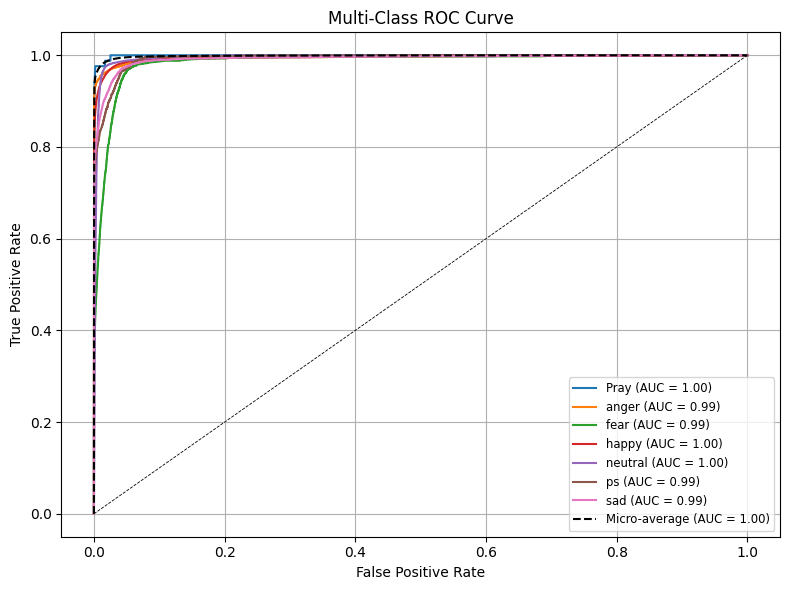

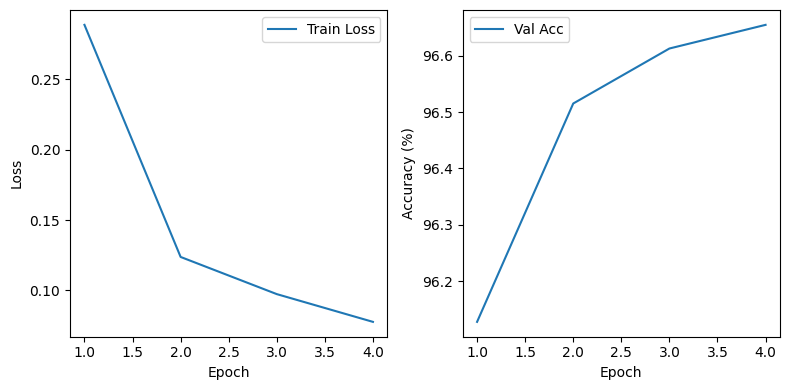

In [2]:
# ===========================================================
# MLP text classification pipeline converted from BERT pipeline
# - TF-IDF vectorizer (fit on train)
# - MLP classifier (feed-forward)
# - augmentations, DataLoader, GPU + mixed-precision, scheduler
# - gradient clipping, tqdm, best-checkpoint saving
# ===========================================================
import os
import random
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup  # reuse the scheduler utility
from torch.optim import AdamW
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, roc_curve, auc


# ------------------------
# Settings
# ------------------------
CSV_PATHS = [
    r"K:\Code\Project\Research Paper\Emotion Detection\archive_text\tweet_emotions.csv",
    r"K:\Code\Project\Research Paper\Emotion Detection\archive_text\dataset2.csv",
    r"K:\Code\Project\Research Paper\Emotion Detection\archive_text\dataset3_excel.csv"
]
EXCLUDE_LABELS = ["pray"]            # keep if you want to exclude some labels
MAX_FEATURES = 20000                 # TF-IDF feature dimension (tune to control memory)
MAX_LEN = 64                         # still available for augmentation decisions (not used by TF-IDF)
BATCH_SIZE = 32
EPOCHS = 4
LR = 2e-4                            # slightly larger LR for small MLP
WEIGHT_DECAY = 1e-2
WARMUP_RATIO = 0.1
NUM_WORKERS = 0
PIN_MEMORY = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BEST_MODEL_PATH = "mlp_emotion_best.pth"
RANDOM_SEED = 42
HIDDEN_DIMS = [1024, 512]           # configurable MLP hidden sizes
DROPOUT = 0.2

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Device:", DEVICE)
print("TF-IDF max features:", MAX_FEATURES)

# ------------------------
# 1) Load & prepare csvs
# ------------------------
dfs = []
for p in CSV_PATHS:
    if os.path.exists(p):
        dfs.append(pd.read_csv(p))
    else:
        print(f"⚠️ CSV not found (skipping): {p}")

if len(dfs) == 0:
    raise RuntimeError("No CSV files found. Update CSV_PATHS.")

df = pd.concat(dfs, ignore_index=True)
df = df.dropna(subset=["content", "sentiment"])
if EXCLUDE_LABELS:
    df = df[~df["sentiment"].isin(EXCLUDE_LABELS)]

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["sentiment"].astype(str))

texts = df["content"].astype(str).tolist()
labels = df["label"].tolist()
num_classes = len(label_encoder.classes_)
print(f"Loaded {len(texts)} texts, {num_classes} classes: {label_encoder.classes_}")

# ------------------------
# 2) Text augmentations (same as before)
# ------------------------
def random_deletion(words, p=0.1):
    if len(words) == 1:
        return words
    remaining = [w for w in words if random.random() > p]
    if len(remaining) == 0:
        return [random.choice(words)]
    return remaining

def random_swap(words, n_swaps=1):
    words = words.copy()
    for _ in range(n_swaps):
        if len(words) < 2:
            break
        i, j = random.sample(range(len(words)), 2)
        words[i], words[j] = words[j], words[i]
    return words

def random_insertion(words, n_ins=1):
    words = words.copy()
    for _ in range(n_ins):
        idx = random.randrange(len(words))
        words.insert(idx, words[idx])  # simple duplication insertion
    return words

def augment_text(text, p_aug=0.3):
    if random.random() >= p_aug:
        return text
    words = text.split()
    choice_aug = random.choice(["del", "swap", "ins"])
    if choice_aug == "del":
        words = random_deletion(words, p=0.12)
    elif choice_aug == "swap":
        words = random_swap(words, n_swaps=1)
    else:
        words = random_insertion(words, n_ins=1)
    return " ".join(words)

# ------------------------
# 3) Train/Val split -> vectorizer fit on train only
# ------------------------
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=RANDOM_SEED, stratify=labels
)

# Fit TF-IDF on training texts only (prevents leakage)
vectorizer = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(1,2), min_df=2)
print("Fitting TF-IDF on training texts...")
vectorizer.fit(train_texts)
input_dim = len(vectorizer.get_feature_names_out())
print(f"TF-IDF vocabulary size (input dim): {input_dim}")

# ------------------------
# 4) Dataset (vectorized)
# ------------------------
class TextVectorDataset(Dataset):
    def __init__(self, texts, labels, vectorizer, augment=False, p_aug=0.3):
        self.texts = texts
        self.labels = labels
        self.vectorizer = vectorizer
        self.augment = augment
        self.p_aug = p_aug

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        if self.augment:
            text = augment_text(text, p_aug=self.p_aug)
        # vectorize single sample (returns 1xD sparse matrix) -> convert to dense numpy
        vec = self.vectorizer.transform([text]).toarray().astype(np.float32)[0]
        features = torch.tensor(vec, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {"features": features, "labels": label}

# DataLoaders
train_dataset = TextVectorDataset(train_texts, train_labels, vectorizer, augment=True, p_aug=0.3)
val_dataset = TextVectorDataset(val_texts, val_labels, vectorizer, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))

# ------------------------
# 5) MLP model
# ------------------------
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[1024,512], dropout_prob=0.2):
        super().__init__()
        layers = []
        cur_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(cur_dim, h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout_prob))
            cur_dim = h
        layers.append(nn.Linear(cur_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = MLPClassifier(input_dim=input_dim, num_classes=num_classes, hidden_dims=HIDDEN_DIMS, dropout_prob=DROPOUT)
model = model.to(DEVICE)

# ------------------------
# 6) Optimizer, scheduler, loss, amp, clipping
# ------------------------
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() if DEVICE.type == "cuda" else None

# ------------------------
# 7) Training loop (adjusted to use 'features')
# ------------------------
def train_loop(model, train_loader, val_loader, epochs,
               optimizer, scheduler, criterion, scaler,
               device, best_model_path=BEST_MODEL_PATH):
    best_val_acc = 0.0
    train_losses, val_accuracies = [], []

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", unit="batch")
        for batch in train_pbar:
            optimizer.zero_grad(set_to_none=True)
            features = batch["features"].to(device, non_blocking=True)
            labels = batch["labels"].to(device, non_blocking=True)

            if scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(features)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(features)
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, dim=1)
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

            train_pbar.set_postfix({
                "loss": f"{running_loss/running_total:.4f}",
                "acc": f"{100*running_correct/running_total:.2f}%"
            })

            # step scheduler per step (keeps behavior similar to transformer workflows)
            scheduler.step()

        epoch_train_loss = running_loss / running_total
        epoch_train_acc = 100 * running_correct / running_total
        train_losses.append(epoch_train_loss)

        # validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]", unit="batch")
            for batch in val_pbar:
                features = batch["features"].to(device, non_blocking=True)
                labels = batch["labels"].to(device, non_blocking=True)

                if scaler is not None:
                    with torch.cuda.amp.autocast():
                        outputs = model(features)
                else:
                    outputs = model(features)

                _, preds = torch.max(outputs, dim=1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

                val_pbar.set_postfix({
                    "acc": f"{100*val_correct/val_total:.2f}%"
                })

        epoch_val_acc = 100 * val_correct / val_total
        val_accuracies.append(epoch_val_acc)
        print(f"\nEpoch {epoch}/{epochs} summary: Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%")

        # save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save({
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "label_encoder": label_encoder,
                "vectorizer": vectorizer,   # save vectorizer for inference
                "epoch": epoch,
                "val_acc": best_val_acc
            }, best_model_path)
            print(f"💾 Best model saved (val_acc={best_val_acc:.2f}%)")

    return train_losses, val_accuracies, best_val_acc
def evaluate_model(model, val_loader, label_encoder, device):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating", unit="batch"):
            features = batch["features"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(features)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_score = np.concatenate(all_probs)
    y_pred = np.argmax(y_score, axis=1)

    print("\n=== Classification Report (Precision, Recall, F1) ===")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))

    # ----- ROC Curve -----
    y_true_bin = label_binarize(y_true, classes=list(range(len(label_encoder.classes_))))
    plt.figure(figsize=(8,6))
    fpr, tpr, roc_auc = {}, {}, {}
    for i, cls in enumerate(label_encoder.classes_):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=1.5, label=f"{cls} (AUC = {roc_auc[i]:.2f})")

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], linestyle='--', color='black',
             label=f"Micro-average (AUC = {roc_auc['micro']:.2f})")
    plt.plot([0,1],[0,1],'k--',lw=0.6)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(fontsize="small", loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# ------------------------
# 8) Run training (or load model)
# ------------------------
choice = input("Train model? (yes/no): ").strip().lower()
if choice == "yes":
    train_losses, val_accuracies, best_acc = train_loop(
        model, train_loader, val_loader, EPOCHS,
        optimizer, scheduler, criterion, scaler, DEVICE, BEST_MODEL_PATH
    )
    print(f"🏁 Training finished. Best val acc: {best_acc:.2f}%")
    evaluate_model(model, val_loader, label_encoder, DEVICE)


    # plot
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    if os.path.exists(BEST_MODEL_PATH):
        ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
        model.load_state_dict(ckpt["model_state"])
        # if saved, also update vectorizer and label encoder objects
        vectorizer = ckpt.get("vectorizer", vectorizer)
        label_encoder = ckpt.get("label_encoder", label_encoder)
        print("📦 Loaded best model.")
    else:
        print("⚠️ No saved model found, please train first.")
# ------------------------
# 9) Evaluation: Precision, Recall, F1, ROC curve
# ------------------------


# ------------------------
# 9) Inference helper
# ------------------------
def predict_emotion(text):
    model.eval()
    text = str(text)
    vec = vectorizer.transform([text]).toarray().astype(np.float32)
    features = torch.tensor(vec, dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        if DEVICE.type == "cuda" and scaler is not None:
            with torch.cuda.amp.autocast():
                out = model(features)
        else:
            out = model(features)
    _, pred = torch.max(out, dim=1)
    emotion = label_encoder.inverse_transform([pred.item()])[0]
    return emotion

# ------------------------
# 10) Quick interactive loop (optional)
# ------------------------
while True:
    s = input("\nEnter text (or 'quit'): ")
    if s.strip().lower() == "quit":
        break
    print("Predicted Emotion:", predict_emotion(s))
